In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 120
np.random.seed(101)

In [2]:
data_path = Path('../data/final_results.csv')

if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback dataset
    df = pd.DataFrame({
        'scenario': ['baseline','alt_impute','alt_outlier'],
        'return': [0.12, 0.11, 0.135],
        'volatility': [0.18, 0.185, 0.19],
        'sharpe': [0.56, 0.49, 0.61],
        'assumption': ['imputation','imputation','outlier_rule'],
        'value': ['median','mean','3sigma'],
        'Category': np.random.choice(['X','Y','Z'], 3),
        'MetricA': np.random.normal(75, 15, 3),
        'MetricB': np.random.normal(150, 30, 3),
        'Date': pd.date_range('2025-02-01', periods=3)
    })
print(df)

      scenario  return  volatility  sharpe    assumption   value Category  \
0     baseline   0.120       0.180    0.56    imputation  median        Y   
1   alt_impute   0.110       0.185    0.49    imputation    mean        Z   
2  alt_outlier   0.135       0.190    0.61  outlier_rule  3sigma        Y   

     MetricA     MetricB       Date  
0  75.037206   99.563014 2025-02-01  
1  74.456082  175.913737 2025-02-02  
2  84.236667  128.274684 2025-02-03  


In [3]:
img_dir = Path('../deliverables/images')
img_dir.mkdir(parents=True, exist_ok=True)

def savefig(name):
    plt.tight_layout()
    plt.savefig(img_dir / name, dpi=300)
    print(f'Saved {name}')

Saved risk_return_annotated.png


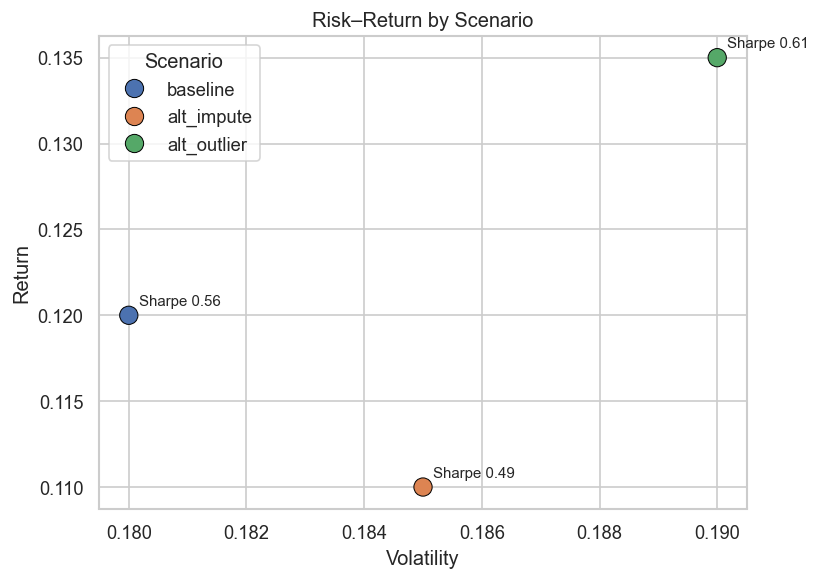

In [4]:
# --- Risk–Return scatter (polished) with Sharpe annotations ---
plt.figure(figsize=(7,5))
ax = sns.scatterplot(data=df, x='volatility', y='return', hue='scenario', s=120, edgecolor='black', linewidth=0.6)
for _, r in df.iterrows():
    ax.annotate(f"Sharpe {r['sharpe']:.2f}", (r['volatility'], r['return']),
                xytext=(6,6), textcoords='offset points', fontsize=9)
plt.title('Risk–Return by Scenario')
plt.xlabel('Volatility'); plt.ylabel('Return')
plt.legend(title='Scenario', frameon=True)
savefig('risk_return_annotated.png')
plt.show()


Saved return_by_scenario_annotated.png


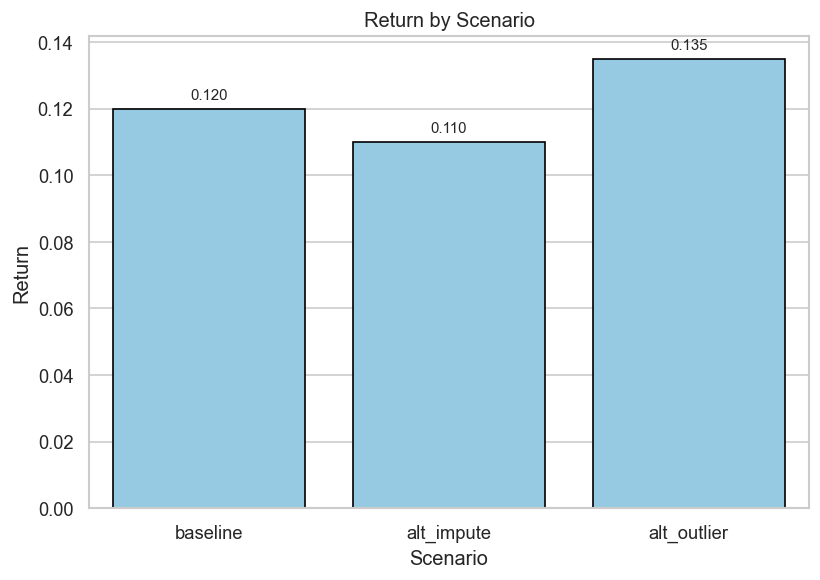

In [5]:
# --- Return by Scenario (polished) ---
plt.figure(figsize=(7,5))
ax = sns.barplot(data=df, x='scenario', y='return', color='#89CFF0', edgecolor='black')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}", (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', xytext=(0,4), textcoords='offset points', fontsize=9)
plt.title('Return by Scenario')
plt.xlabel('Scenario'); plt.ylabel('Return')
savefig('return_by_scenario_annotated.png')
plt.show()


Saved metricA_over_time_polished.png


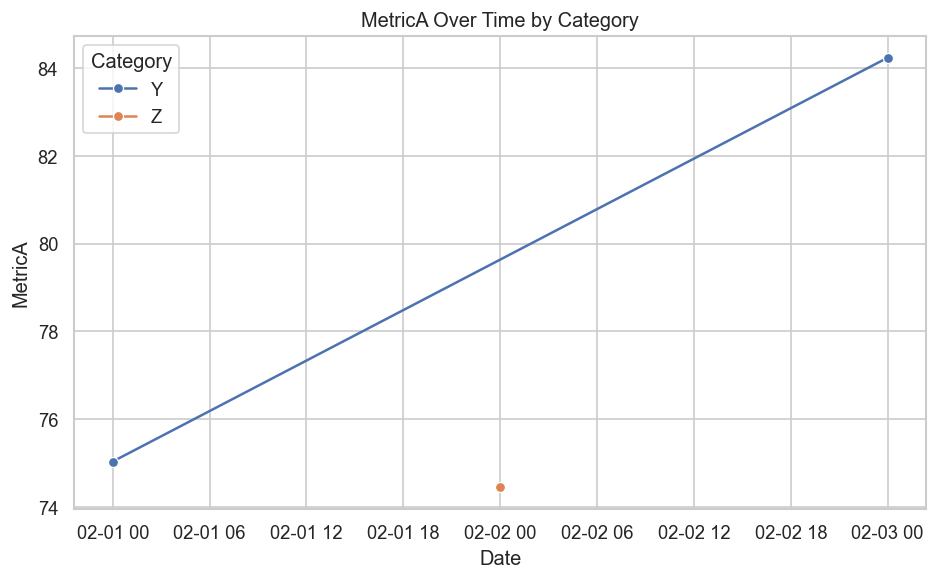

In [6]:
# --- MetricA Over Time by Category (polished) ---
plt.figure(figsize=(8,5))
ax = sns.lineplot(data=df, x='Date', y='MetricA', hue='Category', marker='o')
plt.title('MetricA Over Time by Category')
plt.xlabel('Date'); plt.ylabel('MetricA')
plt.xticks(rotation=0)
plt.legend(title='Category', frameon=True)
savefig('metricA_over_time_polished.png')
plt.show()


In [7]:
# --- Sensitivity table: deltas vs baseline ---
# If your real data has multiple rows per scenario, replace this with grouped summaries.
baseline_row = df.loc[df['scenario'].eq('baseline')].head(1)
if baseline_row.empty:
    raise ValueError("No 'baseline' scenario found; add or rename scenarios accordingly.")

base_ret = float(baseline_row['return'])
base_vol = float(baseline_row['volatility'])
base_shp = float(baseline_row['sharpe'])

sens_tbl = df.copy()
sens_tbl['delta_return'] = sens_tbl['return'] - base_ret
sens_tbl['delta_volatility'] = sens_tbl['volatility'] - base_vol
sens_tbl['delta_sharpe'] = sens_tbl['sharpe'] - base_shp

# Keep the essentials
sens_view = sens_tbl[['scenario','assumption','value','return','volatility','sharpe',
                      'delta_return','delta_volatility','delta_sharpe']].sort_values('delta_return', ascending=False)
sens_view


/var/folders/hc/lx21f3657gz88_xv7kjd578w0000gn/T/ipykernel_18898/2400660106.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_ret = float(baseline_row['return'])
/var/folders/hc/lx21f3657gz88_xv7kjd578w0000gn/T/ipykernel_18898/2400660106.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_vol = float(baseline_row['volatility'])
/var/folders/hc/lx21f3657gz88_xv7kjd578w0000gn/T/ipykernel_18898/2400660106.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_shp = float(baseline_row['sharpe'])


,scenario,assumption,value,return,volatility,sharpe,delta_return,delta_volatility,delta_sharpe
2,alt_outlier,outlier_rule,3sigma,0.135,0.190,0.61,0.015,0.010,0.05
0,baseline,imputation,median,0.120,0.180,0.56,0.000,0.000,0.00
1,alt_impute,imputation,mean,0.110,0.185,0.49,-0.010,0.005,-0.07


Saved tornado_delta_return.png


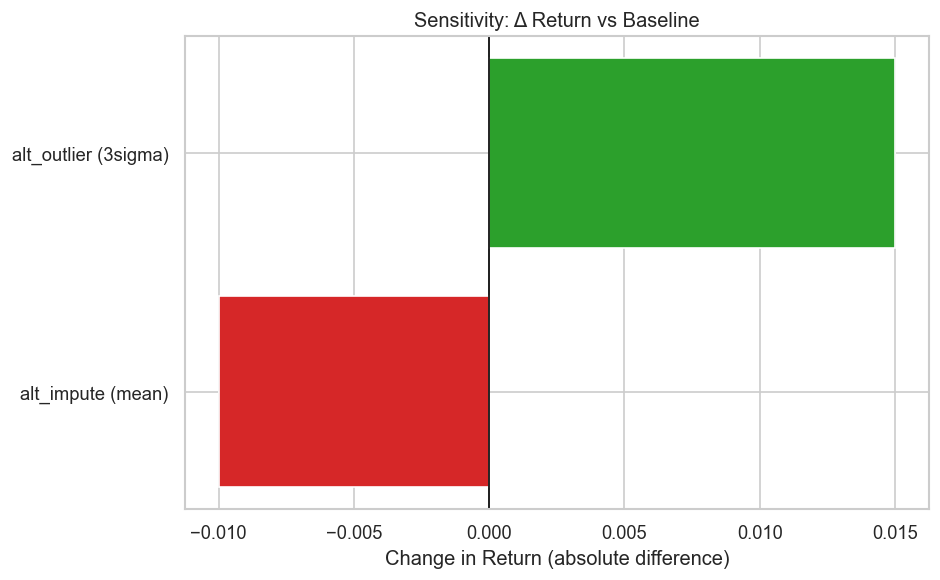

In [8]:
# --- Tornado-style bar chart: Δ Return vs Baseline ---
plot_data = sens_view[sens_view['scenario']!='baseline'].copy()
plot_data = plot_data.sort_values('delta_return', key=lambda s: s.abs(), ascending=True)

plt.figure(figsize=(8,5))
colors = plot_data['delta_return'].apply(lambda x: '#2ca02c' if x>=0 else '#d62728')
plt.barh(plot_data['scenario'] + " (" + plot_data['value'].astype(str) + ")", plot_data['delta_return'], color=colors)
plt.axvline(0, color='black', linewidth=1)
plt.title('Sensitivity: Δ Return vs Baseline')
plt.xlabel('Change in Return (absolute difference)')
savefig('tornado_delta_return.png')
plt.show()


In [10]:
alt_impute_val = df.loc[df['scenario'].eq('alt_impute'), 'return'].head(1)
alt_outlier_val = df.loc[df['scenario'].eq('alt_outlier'), 'return'].head(1)

alt_impute_val = float(alt_impute_val.iloc[0]) if not alt_impute_val.empty else np.nan
alt_outlier_val = float(alt_outlier_val.iloc[0]) if not alt_outlier_val.empty else np.nan

assumptions = pd.DataFrame({
    'Assumption': ['Fill Nulls: Median', 'Remove Outliers: 3σ'],
    'Baseline Return': [base_ret, base_ret],
    'Alt Scenario Return': [alt_impute_val, alt_outlier_val],
})
assumptions['Δ Return'] = assumptions['Alt Scenario Return'] - assumptions['Baseline Return']
assumptions.to_csv(tables_dir / 'assumption_summary.csv', index=False)
assumptions

,Assumption,Baseline Return,Alt Scenario Return,Δ Return
0,Fill Nulls: Median,0.12,0.110,-0.010
1,Remove Outliers: 3σ,0.12,0.135,0.015
